<a href="https://colab.research.google.com/github/zzunebye/Capstone-code-data/blob/main/_CLF_BERT_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install torch

     |████████████████████████████████| 1.9MB 5.7MB/s 
     |████████████████████████████████| 890kB 17.9MB/s 
     |████████████████████████████████| 3.2MB 22.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=36fe70532396e03562e005c6035323fc3aeffa556810a5cd1f75f2e6f73a1d37
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import os
print(os.getcwd())

# 실행시 등장하는 URL을 클릭하여 허용해주면 인증KEY가 나타난다. 복사하여 URL아래 빈칸에 붙여넣으면 마운트에 성공하게된다.
from google.colab import drive
drive.mount('./MyDrive')

/content
Mounted at ./MyDrive


In [3]:
cd MyDrive/MyDrive/Capstone/code_data

/content/MyDrive/MyDrive/Capstone/code_data


In [23]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [5]:
!ls

'2021 Spring.code-workspace'
 BERT_raw_to_fine_tune_ord.pt
 BERT_raw_to_fine_tune_test.pt
 data
 data2.ipynb
 data.ipynb
 FYP_DataScience.code-workspace
'Mobile Computing Group Project Outline.gdoc'
 Model
"Other's code"
'Other'\''s code (1)'
 PHEME_baseline.ipynb
 PHEME_BERTweet.py
 PHEME_BERTweets.ipynb
 PHEME_BERTweets_to_fclayer.ipynb
 PHEME_data_annotated.ipynb
 PHEME_data_integration.ipynb
 PHEME_data.ipynb
 PHEME_data_reaction.ipynb
 PHEME_data_whole_valid.ipynb
 PHEME_DeepLearning.ipynb
 PHEME_eda.ipynb
'PHEME_ipynb to .ipynb'
 pheme_parse.ipynb
 PHEME.py
 PHEME.webscrolling.ipynb
 __pycache__


# Pre-Processing

In [13]:
# raw_text = pd.read_csv('./data/_PHEME_text.csv')
# y = pd.read_csv('./data/_PHEME_target.csv')
# data = pd.concat([raw_text.text, y], axis=1).reset_index(drop=True)

# X = data.text.values
# y = data.target.values

# test_data = pd.read_csv('data/_PHEMEext_text.csv').drop(['Event'],axis=1)
# test_X = test_data.text.values
# test_y = test_data.target.values

# # from sklearn.model_selection import train_test_split
# # # X_train, X_val, y_train, y_val =\
# # #     train_test_split(X, y, test_size=0.1, random_state=2020)

In [18]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


SyntaxError: ignored

# TFIDF

In [19]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X])
X_val_preprocessed = np.array([text_preprocessing(text) for text in test_X])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

KeyboardInterrupt: ignored

In [11]:
print(X_train.shape)
print(X_train_tfidf.shape)

NameError: ignored

In [12]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  1.0


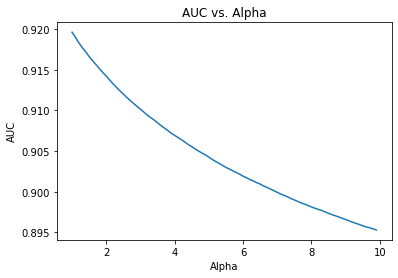

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

AUC: 0.9015
Accuracy: 82.10%


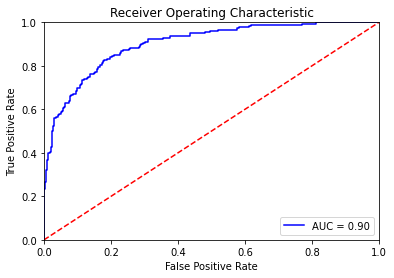

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

AUC: 0.5743
Accuracy: 50.00%


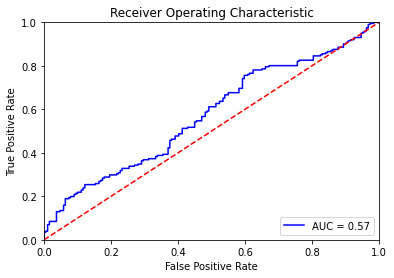

In [ ]:
# Compute predicted probabilities

# X_data = pd.concat([X_train_tfidf, X_val_tfidf], axis=0)
# y_data = pd.concat([X_train_tfidf, X_val_tfidf], axis=0)

X_test = test_data.text.values
y_test = test_data.isRumor.values

X_preprocessed = np.array([text_preprocessing(text) for text in X])
X_tfidf = tf_idf.transform(X_preprocessed)
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_tfidf, y)
probs = nb_model.predict_proba(X_test_tfidf)

# Evaluate the classifier
evaluate_roc(probs, test_data.isRumor)

In [ ]:
from sklearn.metrics import classification_report
preds = np.argmax(probs, axis = 1)
print(classification_report(test_data.isRumor, preds))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       189
           1       1.00      0.03      0.06       201

    accuracy                           0.50       390
   macro avg       0.75      0.51      0.36       390
weighted avg       0.75      0.50      0.35       390



# Fine-tuning BERT

In [26]:
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, roc_curve, auc
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import time

import torch
import torch.nn as nn
from transformers import BertModel

from transformers import AdamW, get_linear_schedule_with_warmup

import random
import time

In [27]:
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = text.lower()
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r"(#)(\S+)", r'\1 \2', text)

    text = re.sub(r"http\S+", "*", text)  # http link -> '*'

    # text = re.sub(r"@\S+", "@", text)   # mention -> '@'
    text = re.sub(r"@[^\s]+", "@", text)   # mention -> '@'

    # sent = re.sub(r"(#)(\S+)", r'\1 \2', sent)
    # sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Create a function to tokenize a set of texts


def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs (빈 리스트 2개 생성)
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            # return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
        )

        # Add the outputs to the lists (위의 빈 리스트에 상응하는 값 추가)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors (리스트들을 텐서화)
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

# Create the BertClassfier class


class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """

    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits


def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    criterion = nn.CrossEntropyLoss()

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler, criterion


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(
                t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(
                    f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


## Pre-Proecess

In [28]:
raw_text = pd.read_csv('./data/_PHEME_text.csv')
y = pd.read_csv('./data/_PHEME_target.csv')
data = pd.concat([raw_text.text, y], axis=1).reset_index(drop=True)
val = pd.read_csv('data/_PHEMEext_text.csv')

X_train = data.text.values
y_train = data.target.values

X_val = val.drop(['Event'],axis=1).text.values
y_val = val.target.values

rhi_data = pd.read_csv('data/_RHI_text.csv')
rhi_y = pd.read_csv('data/_RHI_text.csv')

# from sklearn.model_selection import train_test_split
# # X_train, X_val, y_train, y_val =\
# #     train_test_split(X, y, test_size=0.1, random_state=2020)

In [29]:
# Print sentence 0
print('Original: ', X_val[0])
print('Processed: ', text_preprocessing(X_val[0]))

Original:  Micheal Essien denying the Ebola rumours like https://t.co/H2E1TAzeha
Processed:  micheal essien denying the ebola rumours like *


In [30]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [31]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.text.values, test_data.text.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  69


In [32]:
# Specify `MAX_LEN`
MAX_LEN = 64

# # Print sentence 0 and its encoded token ids
# token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
# print('Original: ', X[0])
# print('\nToken IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('\nTokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [33]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


## Training

In [37]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler, loss_fn = initialize_model(epochs=4)

In [38]:
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.545895   |     -      |     -     |   13.60  
   1    |   40    |   0.431758   |     -      |     -     |   12.85  
   1    |   60    |   0.419819   |     -      |     -     |   12.92  
   1    |   80    |   0.408936   |     -      |     -     |   12.91  
   1    |   100   |   0.364633   |     -      |     -     |   12.93  
   1    |   120   |   0.350773   |     -      |     -     |   12.95  
   1    |   140   |   0.348678   |     -      |     -     |   12.96  
   1    |   160   |   0.342240   |     -      |     -     |   12.95  
   1    |   180   |   0.320228   |     -      |     -     |   12.97  
   1    |   181   |   0.209871   |     -      |     -     |   0.29   
----------------------------------------------------------------------
   1    |    -    |   0.392390   |  0.885340  |   46.80   |  120.61  

In [41]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.7720
Accuracy: 34.23%


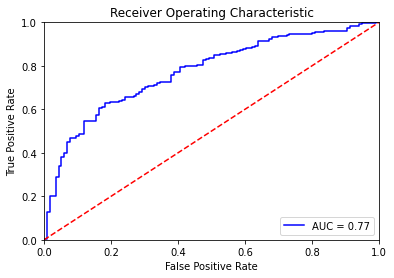

In [42]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [46]:
torch.save(bert_classifier.state_dict(), './Model/BERT_raw_to_fine_tune_ord.pt')
# torch.save(bert_classifier.state_dict(), './BERT_raw_to_fine_tune_test.pt')
# torch.save(model.state_dict, 'model.pt') # saving state dict

## Training (full)

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.519470   |     -      |     -     |   8.42   
   1    |   40    |   0.458738   |     -      |     -     |   8.27   
   1    |   60    |   0.411981   |     -      |     -     |   8.16   
   1    |   80    |   0.388299   |     -      |     -     |   7.95   
   1    |   100   |   0.378233   |     -      |     -     |   7.75   
   1    |   120   |   0.321618   |     -      |     -     |   7.62   
   1    |   140   |   0.334600   |     -      |     -     |   7.57   
   1    |   160   |   0.355007   |     -      |     -     |   7.52   
   1    |   180   |   0.343738   |     -      |     -     |   7.55   
   1    |   181   |   0.211648   |     -      |     -     |   0.14   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapse

## Testing

In [48]:
PATH = './Model/BERT_raw_to_fine_tune_ord.pt'
# bn_state_dict = torch.load('./BERT_raw_to_fine_tune_ord.pt')
# bert_classifier.load_state_dict(bn_state_dict)
bert_classifier.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [50]:
#  Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [51]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted as Rumor: ", preds.sum())

Number of tweets predicted as Rumor:  54


In [54]:
pd.DataFrame(probs)#.idxmax(axis=1))

,0,1
0,0.925041,0.074959
1,0.994930,0.005070
2,0.980860,0.019140
3,0.952689,0.047311
4,0.967151,0.032849
...,...,...
480,0.870599,0.129401
481,0.996000,0.004000
482,0.994768,0.005232
483,0.996281,0.003719


In [56]:
from sklearn.metrics import classification_report
preds = np.argmax(probs, axis = 1)
print(classification_report(test_data.target, preds))

              precision    recall  f1-score   support

           0       0.26      0.98      0.42       116
           1       0.96      0.14      0.25       369

    accuracy                           0.34       485
   macro avg       0.61      0.56      0.33       485
weighted avg       0.80      0.34      0.29       485



In [ ]:
output = test_data[preds==1]
output
# list(output.text)

,text,isRumor
7,Family claims #CorneliusGurlitt was mentally u...,1
110,The plot thickens: #Gurlitt's cousin claims Mu...,0
113,Munich District Court has confirmed the applic...,0
134,Munich District Court has confirmed the applic...,0
144,Unconfirmed reports claim that Michael Essien ...,1
147,AC Milan have denied reports that midfielder M...,1
148,Breaking news: Ghana international and AC Mila...,1
149,BREAKING: Unconfirmed reports claim AC Milan m...,1
150,AC Milan midfielder Michael Essien has been di...,1
151,AC Milan have confirmed that the reports about...,1


## Testing

In [68]:
# raw_text = pd.read_csv('./data/_RHI_text.csv')
# # y = pd.read_csv('./data/_RHI_target.csv')
# data = pd.concat([raw_text.text, y], axis=1).reset_index(drop=True)
# val = pd.read_csv('data/_PHEMEext_text.csv')

# X_train = data.text.values
# y_train = data.target.values

# X_val = val.drop(['Event'],axis=1).text.values
# y_val = val.target.values

rhi_data = pd.read_csv('data/_RHI_text.csv')
rhi_y = pd.read_csv('data/_RHI_text.csv')

X_test = rhi_data.text.values
y_test = rhi_y.isRumor.values

# from sklearn.model_selection import train_test_split
# # X_train, X_val, y_train, y_val =\
# #     train_test_split(X, y, test_size=0.1, random_state=2020)

In [58]:
PATH = './Model/BERT_raw_to_fine_tune_ord.pt'
# bn_state_dict = torch.load('./BERT_raw_to_fine_tune_ord.pt')
# bert_classifier.load_state_dict(bn_state_dict)
bert_classifier.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [70]:
#  Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

# Convert other data types to torch.Tensor
test_labels = torch.tensor(y_test)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [71]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted as Rumor: ", preds.sum())

Number of tweets predicted as Rumor:  91


In [72]:
pd.DataFrame(probs)#.idxmax(axis=1))

,0,1
0,0.483309,0.516691
1,0.997296,0.002704
2,0.997502,0.002498
3,0.927679,0.072321
4,0.997721,0.002279
...,...,...
5222,0.997374,0.002626
5223,0.998007,0.001993
5224,0.996135,0.003865
5225,0.993574,0.006426


In [1]:
from sklearn.metrics import classification_report, accuracy_score
preds = np.argmax(probs, axis = 1)
print(classification_report(y_test, preds))

NameError: ignored

In [78]:
output = y_test[preds==0].sum()
output
# list(output.text)

4682

In [75]:
test_data[preds==0]

ValueError: ignored